# Option implied probability density surface

In [ ]:
# Setup for the notebook
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline, CloughTocher2DInterpolator
from matplotlib import cbook, cm
from matplotlib.colors import LightSource

# plt.style.use('ggplot')
plt.style.use("seaborn-v0_8-whitegrid")

from quantform.pylib import QfDate
from quantform.pylib.equity.utils import parse_option_id, form_option_id
from quantform.pylib.equity.derivative import Option
from quantform.pylib.curve import ImpliedVolatilityCurve, DiscountCurve
from quantform.pylib.equity.pricer import PathIndependentBreedenLitzenbergerPricer

## Implied volatility curves

In [2]:
project_root = Path(os.path.abspath(""))

report_date = QfDate(2025, 8, 15)

# The used risk-free rate is the yield of a two year US Treasury quoted EOD 2025-08-15
risk_free_rate = 0.03755

# The value of the underlying is also quoted EOD 2025-08-15. Use a slightly smaller value so that the implied vol can be
# calculated. This is required as the bids and asks might not be up to date
underlying_value = 630  # Actual 643.44 USD

# Read the market data from a CSV file. The market data covers the option prices quoted EOD 2025-08-15 for all available SPY options
option_df = pd.read_csv(project_root / "example_data" / "SPY_Calls_2025-08-15.tsv", sep='\t')

# Function that creates an Option object from the given option price data. If the implied volatility cannot be calculated skips the option
def to_option(row: pd.Series) -> Option:
  # If the implied volatility is marked as zero in Yahoo Finance it most likely cannot be calculated
  if row["Implied Volatility"] == "0.00%":
    # print(f"Invalid implied volatility with option {row["Contract Name"]}!")
    return
  try:
    return Option(row["Contract Name"], *parse_option_id(row["Contract Name"]), risk_free_rate=risk_free_rate, 
                  market_price=(row["Bid"] + row["Ask"]) / 2, underlying_value=underlying_value, report_date=report_date)
  except AssertionError as e:
    # print(f"Not able to calculate the implied volatility for option {row["Contract Name"]}! ({e})")
    return 
         
# Note that calculating the implied volatilities for thousands of options is quite computationally expensive.
# However, as going forward the same underlying value and report date will be used, it is enough to do this just once
options = [to_option(row) for _, row in option_df.iterrows()]
options = [option for option in options if option is not None]

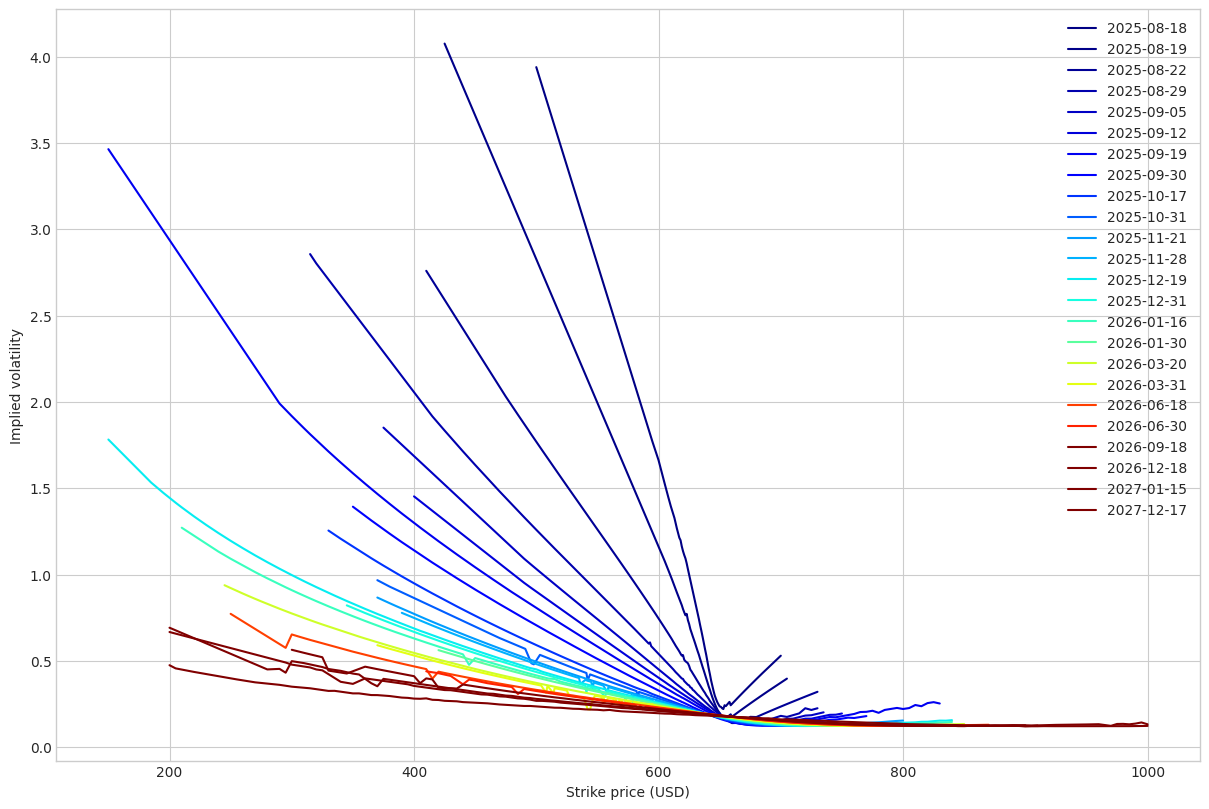

In [31]:
# Additional cleanup of the options might be required. So go over the options and drop the
# ones for which the calculated implied volatility differs significantly from it's neighbors
fig = plt.figure(figsize=(12, 8))

distinct_maturity_dates = list(set([option.maturity_date for option in options]))
distinct_maturity_dates.sort()

taus = np.array([report_date.timedelta(maturity_date) for maturity_date in distinct_maturity_dates])

plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(taus)))

valid_options = []

for maturity_date in distinct_maturity_dates:
  maturity_date_options = [option for option in options if option.maturity_date == maturity_date]
  valid_maturity_date_options = []
  
  for i, option in enumerate(maturity_date_options):
    
    if (i == 0) or (i == len(maturity_date_options) - 1):
      valid_maturity_date_options.append(option)
      continue
    
    expected_vol = (maturity_date_options[i - 1].pricer.volatility + maturity_date_options[i + 1].pricer.volatility) / 2
    
    if abs(expected_vol - option.pricer.volatility) < 0.05:
      valid_maturity_date_options.append(option)
    else:
      # print(f"{option.contract_id}: Expected {expected_vol} found {option.pricer.volatility}")
      pass
      
  maturity_date_vols    = [option.pricer.volatility for option in valid_maturity_date_options]
  maturity_date_strikes = [option.strike for option in valid_maturity_date_options]
  
  plt.plot(maturity_date_strikes, maturity_date_vols, label=str(maturity_date))
  
  valid_options += valid_maturity_date_options

fig.tight_layout()
plt.legend()

plt.xlabel("Strike price (USD)")
plt.ylabel("Implied volatility")

plt.show()

options = valid_options

In [4]:
options = [option for option in options if option.maturity_date not in [QfDate(2025, 8, 20), QfDate(2025, 8, 21), QfDate(2025, 9, 26)]]
distinct_maturity_dates = list(set([option.maturity_date for option in options]))
distinct_maturity_dates.sort()

## Implied volatility surface

In [44]:
strikes    = np.linspace(0, 1500, 100)
vol_values = {} 

for maturity_date in distinct_maturity_dates:
  maturity_date_options = [option for option in options if (option.maturity_date == maturity_date) and (option.strike >= 400) and (option.strike <= 700)]
  curve = ImpliedVolatilityCurve(maturity_date_options, underlying_value, report_date)
  
  vols = []
  for strike in strikes:
    vols.append(curve(strike))
    
  vol_values[maturity_date] = vols
  
maturity_taus = np.array([report_date.timedelta(maturity_date) for maturity_date in distinct_maturity_dates])
taus = np.linspace(maturity_taus[0], maturity_taus[-1], 100)

values = []
points = []

for i in range(len(strikes)):
  vols  = [vol_values[maturity_date][i] for maturity_date in distinct_maturity_dates]
  curve = CubicSpline(maturity_taus, vols)
  
  for tau in taus:
    points.append((strikes[i], tau))
    values.append(curve(tau))
  
volatility_surface = CloughTocher2DInterpolator(points, values)

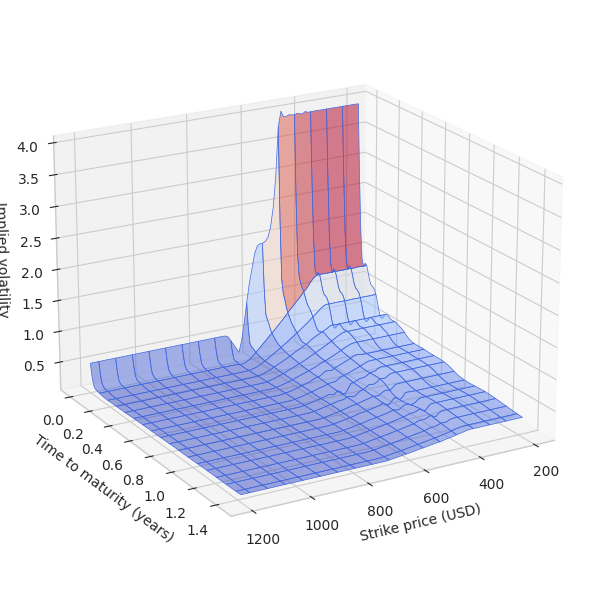

In [115]:
# Only take the options until end of 2026
x, y = np.meshgrid(np.linspace(200, 1200, 100), np.linspace(maturity_taus[0], maturity_taus[22], 100))
z = volatility_surface(x, y)

fig, ax = plt.subplots(figsize=(6.5, 6), subplot_kw=dict(projection='3d'))

# ls = LightSource(0, 0)
# rgb = ls.shade(z, cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')
# surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb, linewidth=0.5, antialiased=True, shade=True)

surf = ax.plot_surface(x, y, z, cmap="coolwarm", edgecolor='royalblue', lw=0.5, rstride=6, cstride=6, alpha=0.5)

ax.view_init(elev=20, azim=60)
ax.set_zlabel("Implied volatility")
ax.set_ylabel("Time to maturity (years)")
ax.set_xlabel("Strike price (USD)")

fig.tight_layout()
fig.savefig(project_root / "figures" / "volatility_surface.png")
plt.show()

## Probability density surface

In [46]:
yield_df = pd.read_csv(project_root / "example_data" / "Treasury_Yields_2025-08-15.tsv", sep=',')
yield_curve = DiscountCurve(yield_df["TTM (Years)"], yield_df["Yield (%)"] / 100)

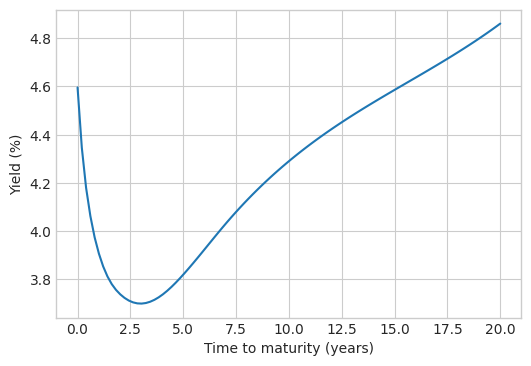

In [47]:
fig = plt.figure(figsize=(6, 4))

xx = np.linspace(0, 20, 100)
yy = [yield_curve(x) * 100 for x in xx]

plt.plot(xx, yy)
plt.xlabel("Time to maturity (years)")
plt.ylabel("Yield (%)")

plt.show()

In [48]:
points = []
values = []

for i, tau in enumerate(taus):
  print(f"Progress: {i+1} / {len(taus)}")
  
  maturity_date  = report_date * tau
  treasury_yield = yield_curve(tau)
  vol_curve = CubicSpline(strikes, volatility_surface([(strike, tau) for strike in strikes]))
  
  bl_pricer = PathIndependentBreedenLitzenbergerPricer(maturity_date, lambda x: x, vol_curve, treasury_yield)
  pdf_curve = bl_pricer.implied_density(underlying_value, report_date, (0, 1500))
  
  for strike in strikes:
    points.append((strike, tau))
    values.append(pdf_curve(strike))
    
pdf_surface = CloughTocher2DInterpolator(points, values)

Progress: 1 / 100


/home/kasper/GIT/quantform/src/quantform/pylib/equity/pricer/BlackScholesPricer.py:161: RuntimeWarning: divide by zero encountered in scalar divide
  (np.log(underlying_value / self.__strike) + (self.__rf + self.__vol ** 2 / 2) * \


Progress: 2 / 100
Progress: 3 / 100
Progress: 4 / 100
Progress: 5 / 100
Progress: 6 / 100
Progress: 7 / 100
Progress: 8 / 100
Progress: 9 / 100
Progress: 10 / 100
Progress: 11 / 100
Progress: 12 / 100
Progress: 13 / 100
Progress: 14 / 100
Progress: 15 / 100
Progress: 16 / 100
Progress: 17 / 100
Progress: 18 / 100
Progress: 19 / 100
Progress: 20 / 100
Progress: 21 / 100
Progress: 22 / 100
Progress: 23 / 100
Progress: 24 / 100
Progress: 25 / 100
Progress: 26 / 100
Progress: 27 / 100
Progress: 28 / 100
Progress: 29 / 100
Progress: 30 / 100
Progress: 31 / 100
Progress: 32 / 100
Progress: 33 / 100
Progress: 34 / 100
Progress: 35 / 100
Progress: 36 / 100
Progress: 37 / 100
Progress: 38 / 100
Progress: 39 / 100
Progress: 40 / 100
Progress: 41 / 100
Progress: 42 / 100
Progress: 43 / 100
Progress: 44 / 100
Progress: 45 / 100
Progress: 46 / 100
Progress: 47 / 100
Progress: 48 / 100
Progress: 49 / 100
Progress: 50 / 100
Progress: 51 / 100
Progress: 52 / 100
Progress: 53 / 100
Progress: 54 / 100
P

/home/kasper/GIT/quantform/src/quantform/pylib/equity/pricer/PathIndependentBreedenLitzenbergerPricer.py:129: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  norm_factor = 1 / quad(unnorm_pdf, integration_interval[0], integration_interval[1])[0]


Progress: 70 / 100


/home/kasper/GIT/quantform/src/quantform/pylib/curve/ProbabilityDensityCurve.py:112: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(integrand, self.__min, self.__max)[0]


Progress: 71 / 100
Progress: 72 / 100
Progress: 73 / 100
Progress: 74 / 100
Progress: 75 / 100
Progress: 76 / 100
Progress: 77 / 100
Progress: 78 / 100
Progress: 79 / 100
Progress: 80 / 100
Progress: 81 / 100
Progress: 82 / 100
Progress: 83 / 100
Progress: 84 / 100
Progress: 85 / 100
Progress: 86 / 100
Progress: 87 / 100
Progress: 88 / 100
Progress: 89 / 100
Progress: 90 / 100
Progress: 91 / 100
Progress: 92 / 100
Progress: 93 / 100
Progress: 94 / 100
Progress: 95 / 100
Progress: 96 / 100
Progress: 97 / 100
Progress: 98 / 100
Progress: 99 / 100
Progress: 100 / 100


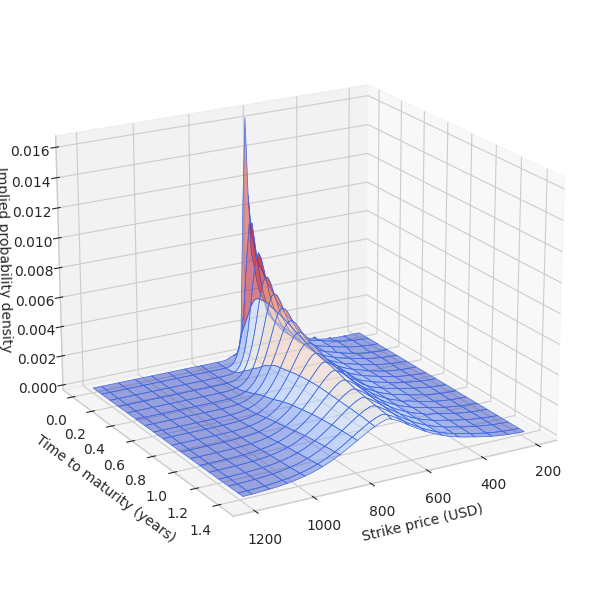

In [ ]:
# Only take the options until end of 2026
x, y = np.meshgrid(np.linspace(200, 1200, 100), np.linspace(maturity_taus[0], maturity_taus[22], 100))
z = pdf_surface(x, y)

fig, ax = plt.subplots(figsize=(6.5, 6), subplot_kw=dict(projection='3d'))

# ls = LightSource(0, 0)
# rgb = ls.shade(z, cmap=cm.coolwarm, vert_exag=0.1, blend_mode='soft')
# surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb, linewidth=0.5, antialiased=True, shade=True)  #edgecolor='royalblue', lw=0.5, rstride=6, cstride=6, alpha=0.5)

surf = ax.plot_surface(x, y, z, cmap="coolwarm", edgecolor='royalblue', lw=0.5, rstride=6, cstride=6, alpha=0.5)

ax.view_init(elev=20, azim=60)
ax.set_zlabel("Implied probability density")
ax.set_ylabel("Time to maturity (years)")
ax.set_xlabel("Strike price (USD)")

fig.tight_layout()
fig.savefig(project_root / "figures" / "pdf_surface.png")
plt.show()